In [1]:
%load_ext autoreload
%autoreload 2

In [591]:
import torch
from torch import nn
import numpy as np
from einops import repeat, reduce, rearrange
import matplotlib.pyplot as plt

import train
import models

from tqdm.auto import tqdm


In [188]:
# net = models.GPT(16, 32, 64, 4, 4)
# net = models.WeirdGPT(16, 32, 64, 4, 4)
# net = models.CompressionGPT(16, 32, 64, 4, 4, mode='random')
net = models.CompressionGPT(16, 32, 64, 4, 4, mode='half-full')
logits = net(torch.randint(0, 16, (48, 32)))

In [189]:
net.wpe.weight.mean(), net.wpe.weight.std()

(tensor(-0.0005, grad_fn=<MeanBackward0>),
 tensor(0.0199, grad_fn=<StdBackward0>))

In [190]:
net.wpe_enc.weight.mean(), net.wpe_enc.weight.std()

(tensor(-7.2017e-05, grad_fn=<MeanBackward0>),
 tensor(0.0197, grad_fn=<StdBackward0>))

In [156]:
attn_weights = torch.stack([block.attn_weights for block in net.blocks], dim=1).detach().cpu()
logits = logits.detach().cpu()
logits.shape, attn_weights.shape

(torch.Size([48, 32, 16]), torch.Size([48, 4, 4, 32, 32]))

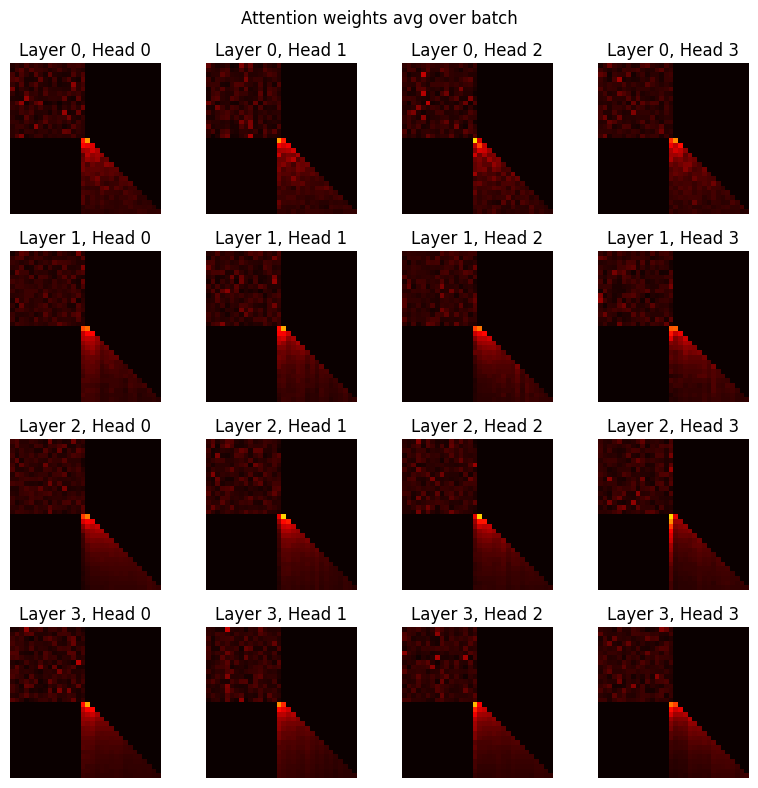

In [157]:
fig = plt.figure(figsize=(net.n_head*2, net.n_layer*2))
for i_layer in range(net.n_layer):
    for i_head in range(net.n_head):
        plt.subplot(net.n_layer, net.n_head, i_layer*net.n_head + i_head + 1)
        plt.imshow(attn_weights[:, i_layer, i_head].mean(dim=0), cmap='hot', vmin=0., vmax=1.)
        plt.title(f'Layer {i_layer}, Head {i_head}')
        plt.axis('off')
        # y = torch.where(~logits.isnan().any(dim=-1).any(dim=0))[0].detach().cpu().numpy()
        # x = np.full(len(y), fill_value=-1)
        # plt.scatter(x, y, marker='x', color='g', s=10)
plt.suptitle('Attention weights avg over batch')
plt.tight_layout()

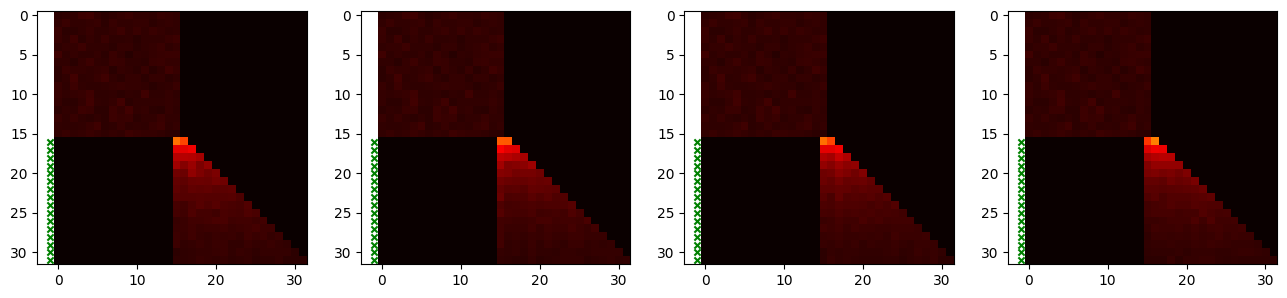

In [158]:
fig = plt.figure(figsize=(4*4, 4))
for i_batch in range(4):
    plt.subplot(1, 4, i_batch + 1)
    plt.imshow(attn_weights[i_batch].mean(dim=(0, 1)), cmap='hot', vmin=0, vmax=1)
    y = torch.where(~logits.isnan().any(dim=-1)[i_batch])[0].numpy()
    x = np.full(len(y), fill_value=-1)
    plt.scatter(x, y, marker='x', color='g', s=20)

In [238]:
teacher = models.CompressionGPT(33, 32, 768, 4, 12, mode='random-causal')
state_dict = torch.load("models/random-causal.pt")
state_dict['mask'] = teacher.mask
teacher.load_state_dict(state_dict)
teacher = teacher.eval()

/Users/akarshkumar0101/miniconda3/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


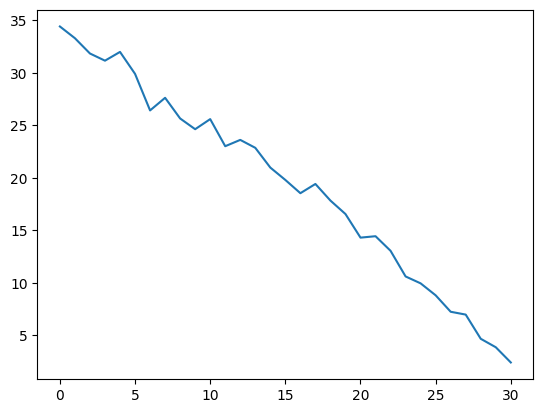

In [240]:
bs = 128
tok = train.generate_batch(33, 32, bs)
x, y = tok[:, :-1], tok[:, 1:]
with torch.no_grad():
    logits = teacher(x, mode='decode-causal')
loss_pred = torch.nn.functional.cross_entropy(rearrange(logits, "b t d -> (b t) d"), rearrange(y, "b t -> (b t)"), reduction="none")
loss_pred = rearrange(loss_pred, "(b t) -> b t", b=bs)
plt.plot(loss_pred.nanmean(dim=0).exp().detach().cpu().numpy())

In [267]:
bs = 16
tok = train.generate_batch(33, 33, bs)
x, y = tok[:, :-1], tok[:, 1:]

with torch.no_grad():
    activations = teacher(x, mode='encode-causal')
    activations = activations[:, :, :-1, :] # can't use last token since its decoder
tok = tok[:, :-2]
activations.shape, tok.shape

/Users/akarshkumar0101/miniconda3/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


(torch.Size([16, 5, 31, 768]), torch.Size([16, 31]))

In [279]:
mem_bef = rearrange(activations[:, :, :-1, :], 'b l t d -> (b t) l d')
mem_aft = rearrange(activations[:, :,  1:, :], 'b l t d -> (b t) l d')
tok_bef = rearrange(tok[:, :-1], 'b t -> (b t)')
tok_aft = rearrange(tok[:,  1:], 'b t -> (b t)')
mem_bef.shape, mem_aft.shape, tok_bef.shape, tok_aft.shape

(torch.Size([480, 5, 768]),
 torch.Size([480, 5, 768]),
 torch.Size([480]),
 torch.Size([480]))

In [299]:
net = models.MyRNN(33, 768, 768, 5, nonlinearity="relu", batch_first=True, dropout=0.0)
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

for i_iter in range(1000):
    tok = train.generate_batch(33, 33, bs)
    x, y = tok[:, :-1], tok[:, 1:]

    with torch.no_grad():
        activations = teacher(x, mode='encode-causal')
        activations = activations[:, :, :-1, :] # can't use last token since its decoder
    tok = tok[:, :-2]
    activations.shape, tok.shape

    mem_bef = rearrange(activations[:, :, :-1, :], 'b l t d -> (b t) l d')
    mem_aft = rearrange(activations[:, :,  1:, :], 'b l t d -> (b t) l d')
    tok_bef = rearrange(tok[:, :-1], 'b t -> (b t)')
    tok_aft = rearrange(tok[:,  1:], 'b t -> (b t)')

    logits, mem = net(tok_bef[:, None], h_0=rearrange(mem_bef, 'b l d -> l b d'), return_hidden_states=True)
    logits = rearrange(logits, "b 1 d -> b d")
    mem = rearrange(mem, 'l b d -> b l d')
    logits.shape, mem.shape


    loss1 = torch.nn.functional.cross_entropy(logits, tok_aft, reduction="none")
    loss2 = (mem-mem_aft).pow(2)

    loss = loss1.mean() + loss2.mean()

    if i_iter%50 ==0:
        print(f'ppl: {loss1.mean().exp().item():8.3f}, mse_mem: {loss2.mean().item():8.3f}')

    opt.zero_grad()
    loss.backward()
    opt.step()


ppl:   44.079, mse_mem:    4.763
ppl:   22.142, mse_mem:    3.680
ppl:   19.349, mse_mem:    3.272
ppl:   18.123, mse_mem:    2.955
ppl:   18.030, mse_mem:    2.819
ppl:   17.995, mse_mem:    2.716
ppl:   18.213, mse_mem:    2.555
ppl:   18.663, mse_mem:    2.542
ppl:   18.470, mse_mem:    2.510
ppl:   18.421, mse_mem:    2.420
ppl:   18.011, mse_mem:    2.427
ppl:   18.583, mse_mem:    2.380
ppl:   17.947, mse_mem:    2.415
ppl:   17.848, mse_mem:    2.352
ppl:   18.039, mse_mem:    2.341
ppl:   18.266, mse_mem:    2.333
ppl:   17.563, mse_mem:    2.331
ppl:   17.097, mse_mem:    2.327
ppl:   17.367, mse_mem:    2.280
ppl:   17.996, mse_mem:    2.312


In [309]:
net = nn.Sequential(models.MLP(768), nn.Linear(768, 33))
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

for i_iter in range(5000):
    tok = train.generate_batch(33, 33, bs)
    x, y = tok[:, :-1], tok[:, 1:]

    with torch.no_grad():
        activations = teacher(x, mode='encode-causal')
        activations = activations[:, :, :-1, :] # can't use last token since its decoder
    tok = tok[:, :-2]
    activations.shape, tok.shape

    mem_bef = rearrange(activations[:, :, :-1, :], 'b l t d -> (b t) l d')
    mem_aft = rearrange(activations[:, :,  1:, :], 'b l t d -> (b t) l d')
    tok_bef = rearrange(tok[:, :-1], 'b t -> (b t)')
    tok_aft = rearrange(tok[:,  1:], 'b t -> (b t)')

    x = mem_bef[:, -1, :]
    y = tok_aft
    logits = net(x)
    loss1 = nn.functional.cross_entropy(logits, y, reduction='none')
    loss = loss1.mean()

    opt.zero_grad()
    loss.backward()
    opt.step()

    if i_iter%250 ==0:
        print(f'i: {i_iter: 8d} ppl: {loss1.mean().exp().item():8.3f}')

/Users/akarshkumar0101/miniconda3/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


i:        0 ppl:   35.741
i:      250 ppl:   17.494
i:      500 ppl:   16.507
i:      750 ppl:   16.165
i:     1000 ppl:   16.178
i:     1250 ppl:   16.876
i:     1500 ppl:   16.389


KeyboardInterrupt: 

In [337]:
class OneStepMLP(nn.Module):
    def __init__(self, n_embd, dropout=0.0, bias=True):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(2*n_embd, 2 * n_embd, bias=bias),
            nn.GELU(),
            nn.Linear(2*n_embd, 2 * n_embd, bias=bias),
            nn.GELU(),
        )

    def forward(self, x):
        x = self.seq(x)
        return x

class OneStepBlock(nn.Module):
    def __init__(self, n_embd, dropout=0.0, bias=True):
        super().__init__()
        self.ln_1 = nn.LayerNorm(2*n_embd)
        self.mlp1 = OneStepMLP(n_embd, dropout=dropout, bias=bias)
        self.ln_2 = nn.LayerNorm(2*n_embd)
        self.mlp2 = OneStepMLP(n_embd, dropout=dropout, bias=bias)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=-1)
        x = x + self.mlp1(self.ln_1(x))
        x = x + self.mlp2(self.ln_2(x))
        x, y = x.chunk(2, dim=-1)
        return x, y

class MyOneStepRecurrentNet(nn.Module):
    def __init__(self, vocab_size, n_embd, n_layer):
        super().__init__()
        self.wte = nn.Embedding(vocab_size, n_embd)
        self.blocks = nn.ModuleList([OneStepBlock(n_embd) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

    def forward(self, tok, mem=None):
        # tok: (bs )
        # mem: (bs, n_layer, d)
        mem_outs = []
        x = self.wte(tok)  # (bs, d)
        for block, memi in zip(self.blocks, rearrange(mem, 'b l d -> l b d')):
            x, memouti = block(x, memi)
            mem_outs.append(memouti)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits, torch.stack(mem_outs, dim=1)



In [338]:
net = MyOneStepRecurrentNet(33, 768, 4+1)
logits, memout = net(torch.randint(0, 33, (16, )), torch.randn(16, 5, 768))
logits.shape, memout.shape

(torch.Size([16, 33]), torch.Size([16, 5, 768]))

In [358]:
net = MyOneStepRecurrentNet(33, 768, 4+1)
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

data = []
for i_iter in tqdm(range(2000)):
    tok = train.generate_batch(33, 33, bs)
    x, y = tok[:, :-1], tok[:, 1:]

    with torch.no_grad():
        activations = teacher(x, mode='encode-causal')
        activations = activations
    
    mem1 = rearrange(activations[:, :, :-2, :], 'b l t d -> (b t) l d') # red
    mem2 = rearrange(activations[:, :,  1:-1, :], 'b l t d -> (b t) l d') # blue
    mem3 = rearrange(activations[:, :,  2:, :], 'b l t d -> (b t) l d') # orange
    tok1 = rearrange(x[:, :-2], 'b t -> (b t)') # red
    tok2 = rearrange(x[:,  1:-1], 'b t -> (b t)') # blue
    tok3 = rearrange(x[:,  2:], 'b t -> (b t)') # orange

    logits, mem2hat = net(tok2, mem1)
    loss1 = nn.functional.cross_entropy(logits, tok3, reduction='none')
    loss2 = (mem2hat- mem2).pow(2)
    loss = 1.*loss1.mean() + loss2.mean()
    opt.zero_grad()
    loss.backward()
    opt.step()

    data.append((loss1.mean().exp().item(), loss2.mean().item()))
    if i_iter%100==0:
        print(f'i: {i_iter: 8d} ppl: {loss1.mean().exp().item():8.3f}, mse: {loss2.mean().item():8.3f}')

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/akarshkumar0101/miniconda3/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._native_multi_head_attention(


i:        0 ppl:   38.417, mse:    0.323
i:      100 ppl:   16.373, mse:    0.266
i:      200 ppl:   15.425, mse:    0.248
i:      300 ppl:   15.566, mse:    0.237
i:      400 ppl:   15.508, mse:    0.228
i:      500 ppl:   15.214, mse:    0.232
i:      600 ppl:   15.085, mse:    0.229
i:      700 ppl:   15.007, mse:    0.228
i:      800 ppl:   15.252, mse:    0.227
i:      900 ppl:   14.621, mse:    0.222
i:     1000 ppl:   15.204, mse:    0.220
i:     1100 ppl:   15.142, mse:    0.221
i:     1200 ppl:   15.150, mse:    0.216
i:     1300 ppl:   14.986, mse:    0.215
i:     1400 ppl:   15.096, mse:    0.211
i:     1500 ppl:   14.803, mse:    0.213
i:     1600 ppl:   14.551, mse:    0.207
i:     1700 ppl:   14.803, mse:    0.210
i:     1800 ppl:   14.625, mse:    0.208
i:     1900 ppl:   14.900, mse:    0.202


In [372]:
bs = 1024
for i_iter in range(1):
    tok = train.generate_batch(33, 33, bs)
    x, y = tok[:, :-1], tok[:, 1:]

    with torch.no_grad():
        activations = teacher(x, mode='encode-causal')
        activations = activations
    
    tok2 = x[:, 1:-1]
    tok3 = x[:, 2:]
    mem = activations[:, :, 0, :]
    logits_stack = []
    for t in range(30):
        logits, mem = net(tok2[:, t], mem[:, :, :])
        logits_stack.append(logits)
    logits = torch.stack(logits_stack, dim=1)

    loss_pred = torch.nn.functional.cross_entropy(rearrange(logits, "b t d -> (b t) d"), rearrange(tok3, "b t -> (b t)"), reduction="none")
    loss_pred = rearrange(loss_pred, "(b t) -> b t", b=bs)
    print(loss_pred.shape)

torch.Size([1024, 30])


In [390]:
loss_pred = loss_pred.detach().cpu()

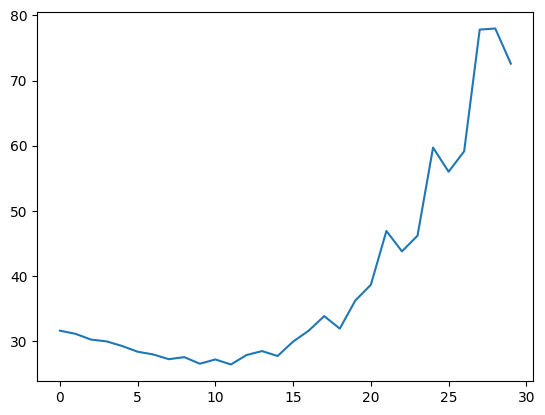

In [391]:
plt.plot(loss_pred.mean(dim=0).exp().numpy())

In [412]:
bs = 1024
tok = train.generate_batch(33, 33, bs)
x, y = tok[:, :-1], tok[:, 1:]
logits = teacher(x)
loss_pred = torch.nn.functional.cross_entropy(rearrange(logits, "b t d -> (b t) d"), rearrange(y, "b t -> (b t)"), reduction="none")
loss_pred = rearrange(loss_pred, "(b t) -> b t", b=bs)

In [415]:
loss_pred.shape

torch.Size([1024, 32])

(0.0, 48.0)

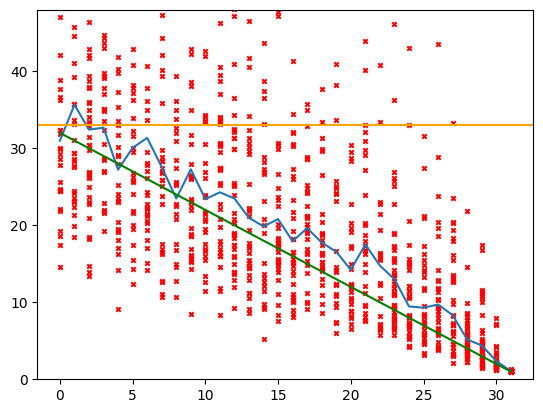

In [443]:
plt.scatter(teacher.idxs_dec, loss_pred.detach().cpu()[torch.arange(bs), teacher.idxs_dec].exp(), s=10., marker='x', c='r')
plt.plot([loss_pred[teacher.idxs_dec==i][:, i].mean().exp().item() for i in range(32)])
plt.plot([33-i-1 for i in range(32)], c='green')
plt.axhline(33, c='orange')
plt.ylim(0, 48)

In [45]:
mha = nn.MultiheadAttention(32, 4, batch_first=True)

In [133]:
x = torch.randn(16, 20, 32)
q = torch.randn(16, 10, 32)
mask = torch.triu(torch.ones(16, 4, 10, 20, dtype=torch.bool), diagonal=1).reshape(64, 10, 20)
mha(q, x, x, attn_mask=mask)[0].shape

torch.Size([16, 10, 32])

torch.Size([16, 32])


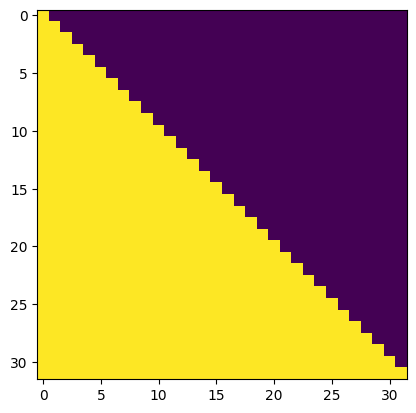

In [154]:
net = models.GPT(32, 32, 32, 4, 4)
tok = torch.randint(0, 32, size=(16, 33))
print(net.loss_fn(tok).shape)
plt.imshow(net.blocks[0].mask)

torch.Size([16, 16])


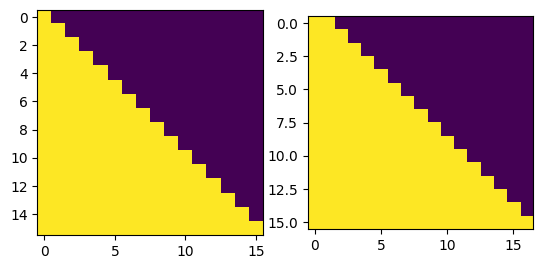

In [157]:
net = models.Compression2AK(32, 32, 32, 4, 4)
tok = torch.randint(0, 32, size=(16, 33))
print(net.loss_fn(tok, i=16).shape)
plt.subplot(121); plt.imshow(net.encoder.blocks[3].mask)
plt.subplot(122); plt.imshow(net.decoder.blocks[3].mask)

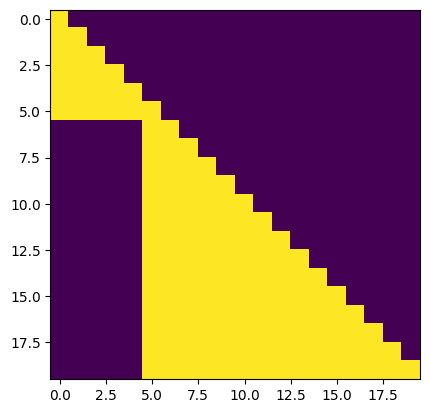

In [218]:
import matplotlib.pyplot as plt
import torch

block_size = 20
mask = torch.tril(torch.ones(block_size, block_size, dtype=torch.bool))
idx_dec = np.random.randint(0, block_size)
mask[idx_dec:, :idx_dec] = False
mask[idx_dec:, np.clip(idx_dec-1, 0, None)] = True
plt.imshow(mask)
plt.show()

In [98]:
vocab_size = 32
block_size = 20
n_embd = 48

bs = 32

net = models.CompressionGPT(vocab_size, block_size, n_embd, 4, 4)

In [99]:
tok = torch.randint(0, vocab_size, size=(bs, block_size))
logits = net(tok)

In [100]:
logits.shape

torch.Size([32, 20, 32])

In [103]:
logits.nanmean(dim=0).isnan().any(dim=-1)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [105]:
logits[0].mean(dim=-1)

tensor([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan, 0.0172, 0.0136, 0.0148, 0.0138,
        0.0165, 0.0135], grad_fn=<MeanBackward1>)

In [107]:
nn.functional.cross_entropy(logits[0], torch.zeros(20, dtype=torch.long), reduction="none")

tensor([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan, 3.4423, 3.4752, 3.4959, 3.5617,
        3.6006, 3.5626], grad_fn=<NllLossBackward0>)

In [319]:
net = models.GPT(32, 32, 768, 12, 12, mask='causal')
tok = torch.randint(0, 32, size=(16, 10))
logits = net(tok)

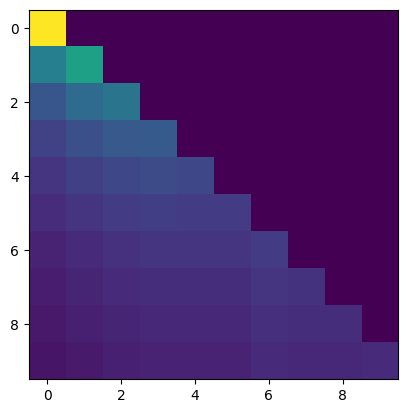

In [324]:
plt.imshow(net.blocks[-1].attn_weights[7, 8].detach().cpu().numpy())

In [592]:
teacher_gpt = models.GPT(33, 32, 768, 4, 12)
teacher_gpt.load_state_dict(torch.load("models/gpt.pt"))
teacher_gpt = teacher_gpt.eval()

teacher_comp = models.CompressionGPT(33, 32, 768, 4, 12, mode='random-causal')
state_dict = torch.load("models/random-causal.pt")
state_dict['mask'] = teacher_comp.mask
teacher_comp.load_state_dict(state_dict)
teacher_comp = teacher_comp.eval()

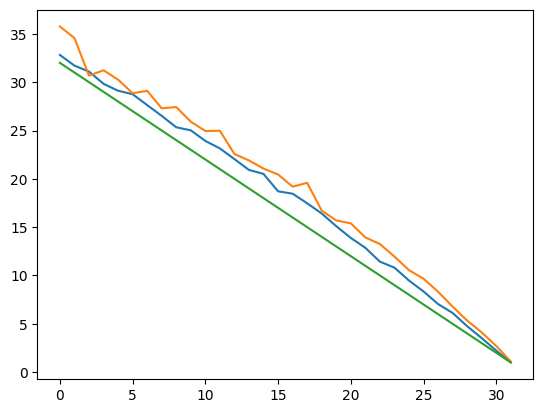

In [593]:
bs = 1024
tok = train.generate_batch(33, 32 + 1, bs, device="cpu")
x, y = tok[:, :-1], tok[:, 1:]
logits = teacher_gpt(x)
loss_pred = torch.nn.functional.cross_entropy(rearrange(logits, "b t d -> (b t) d"), rearrange(y, "b t -> (b t)"), reduction="none")
loss_pred = rearrange(loss_pred, "(b t) -> b t", b=bs)
plt.plot(loss_pred.mean(dim=0).exp().detach().cpu().numpy())
logits = teacher_comp(x, mode='random-causal')
loss_pred = torch.nn.functional.cross_entropy(rearrange(logits, "b t d -> (b t) d"), rearrange(y, "b t -> (b t)"), reduction="none")
loss_pred = rearrange(loss_pred, "(b t) -> b t", b=bs)
plt.plot(loss_pred.nanmean(dim=0).exp().detach().cpu().numpy())
plt.plot(np.arange(32, 0, -1))

In [559]:
logits = teacher_gpt(x)
loss_pred = torch.nn.functional.cross_entropy(rearrange(logits, "b t d -> (b t) d"), rearrange(y, "b t -> (b t)"), reduction="none")
loss_pred = rearrange(loss_pred, "(b t) -> b t", b=bs)

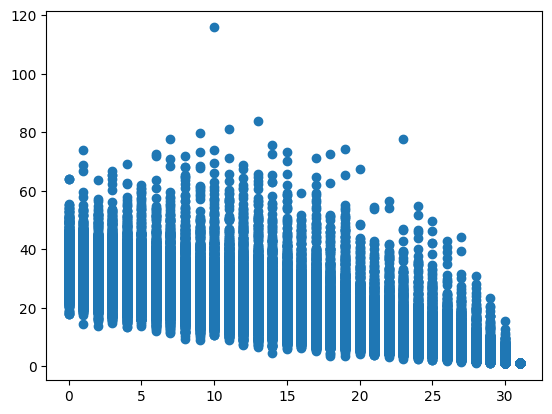

In [562]:
plt.scatter(repeat(np.arange(32), 't -> (b t)', b=1024), loss_pred.detach().cpu().exp().numpy().flatten())

In [587]:
net = models.MyOneStepRecurrentNet(33, 768, 4 + 1)
tok = torch.randint(0, 33, (16, ))
mem = torch.randn(16, 5, 768)
logits, mem = net(tok, mem)
print(logits.shape, mem.shape)

torch.Size([16, 33]) torch.Size([16, 5, 768])


In [588]:
net = models.MyOneStepRecurrentTransformer(33, 768, 2, 12)
tok = torch.randint(0, 33, (16, ))
mem = torch.randn(16, 5, 768)
logits, mem = net(tok, mem)
print(logits.shape, mem.shape)

torch.Size([16, 33]) torch.Size([16, 5, 768])


In [607]:
_ = teacher_comp(x, mode='encode-causal')

In [608]:
attn_weights = torch.stack([block.attn_weights for block in teacher_comp.blocks], dim=1).detach().cpu()

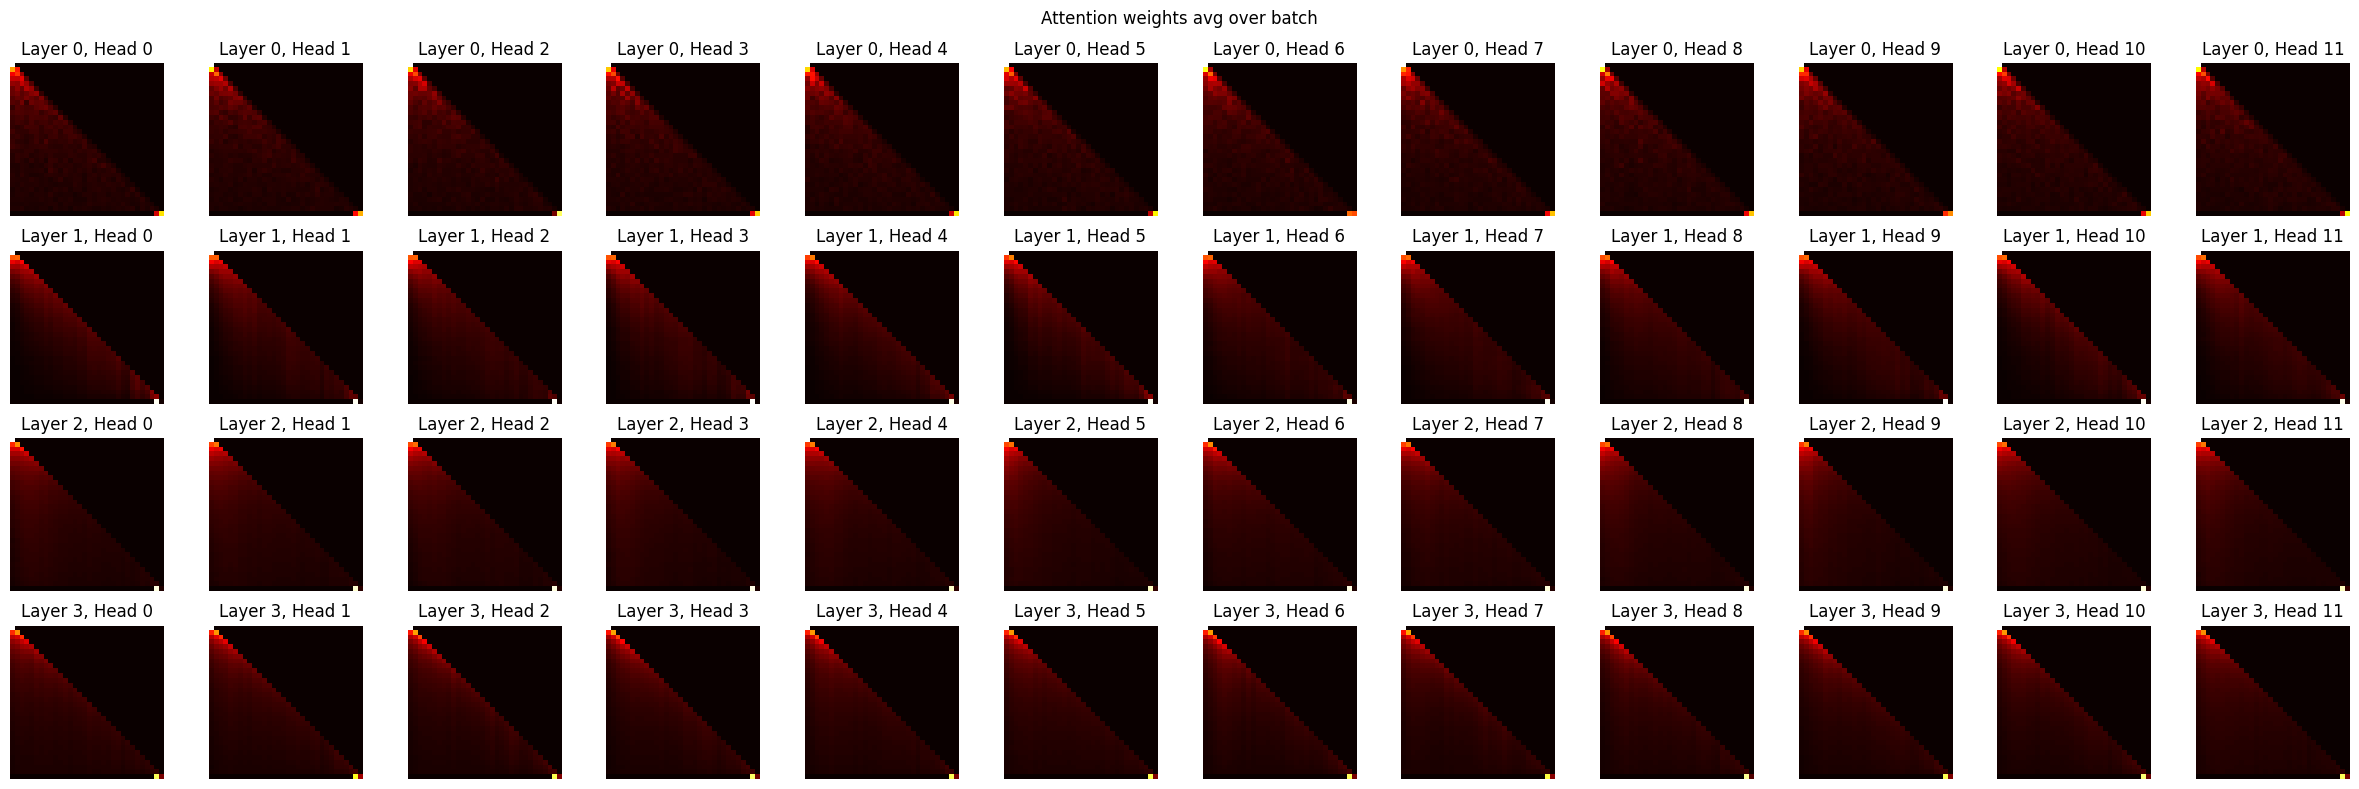

In [609]:

fig = plt.figure(figsize=(teacher_comp.n_head*2, teacher_comp.n_layer*2))
for i_layer in range(teacher_comp.n_layer):
    for i_head in range(teacher_comp.n_head):
        plt.subplot(teacher_comp.n_layer, teacher_comp.n_head, i_layer*teacher_comp.n_head + i_head + 1)
        plt.imshow(attn_weights[:, i_layer, i_head].mean(dim=0), cmap='hot', vmin=0., vmax=1.)
        plt.title(f'Layer {i_layer}, Head {i_head}')
        plt.axis('off')
        # y = torch.where(~logits.isnan().any(dim=-1).any(dim=0))[0].detach().cpu().numpy()
        # x = np.full(len(y), fill_value=-1)
        # plt.scatter(x, y, marker='x', color='g', s=10)
plt.suptitle('Attention weights avg over batch')
plt.tight_layout()

In [306]:
tok = train.generate_batch(10, 10, 10000, device="cpu")
# tok = torch.stack([torch.randperm(30) for _ in range(10000)])

In [307]:
tok.shape

torch.Size([10000, 10])

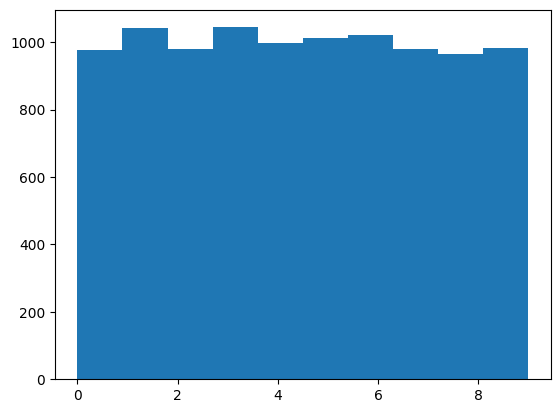

In [308]:
plt.hist(tok[:, 0].flatten().numpy());

In [31]:
torch.__version__

'2.0.1'

In [39]:
net = models.CompressionGPT(33, 32, 768, 4, 12, mode='half')
tok = train.generate_batch(33, 32 + 1, 16, device='cpu')
x, y = tok[:, :-1], tok[:, 1:]
logits = net(x)

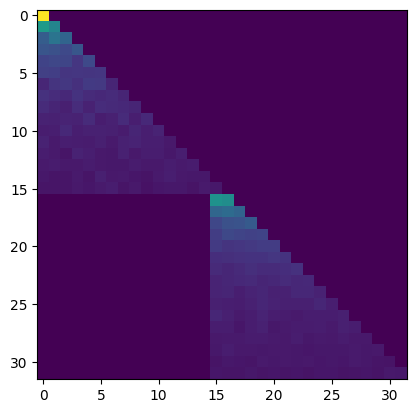

In [44]:
plt.imshow(net.blocks[0].attn_weights.mean(dim=(0, 1)).cpu().detach().numpy())

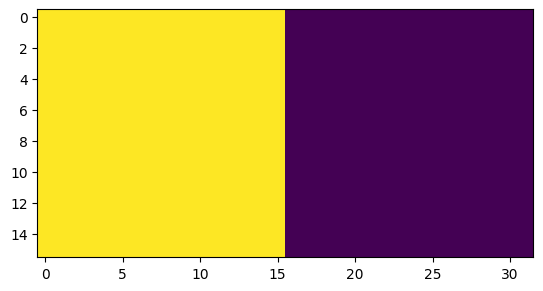

In [48]:
plt.imshow(net.create_compression_batch_mask(torch.arange(32), net.idxs_dec))